# FEM Modelling for STEDIN Transformer

In this part, the conducitvity of the core material is modelled as 0. Therefore, there areno eddy current effects.

## Import Packages

In [1]:
using gmsh
using LinearAlgebra
using LaTeXStrings
using Plots
using CSV
using DataFrames
# include("../../../../lib/Makie_Plots.jl");
# using .Makie_Plots
# include("../../../../lib/FEM_Transient_Tri_1e.jl");
# using .FEM_Transient_Tri_1e
# include("../../../../lib/Post_Process_Time.jl");
# using .Post_Process_Time
# include("../../../../lib/Mesh_Data_stedin.jl");
# using .Mesh_Data_stedin
# include("../../../../lib/Save_VTK.jl");
# using .Save_VTK

using BenchmarkTools
using SparseArrays
using LinearAlgebra
include("../../../../lib/FastSparse.jl");
using .FastSparse

## Julia code

In [2]:
struct meshdata
    nnodes  # number of nodes
    xnode   # array of x coordinates
    ynode   # array of y coordinates
    nelements   # number of elements
    e_group     # array containing the physical group number of each element
    elements    #  more conveniently structured connectivity array
    area    #  area of each element
    Eloc    #  Emat of each element
end

In [3]:
function get_mesh_data_tri_1e(gmsh)
    ## Get and sort the mesh nodes
    node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
    nnodes = length(node_ids)
    #..sort the node coordinates by ID, such that Node one sits at row 1
    tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
    sorted = sortslices(tosort , dims = 1);
    node_ids = sorted[:,1]
    xnode = sorted[:,2]
    ynode = sorted[:,3]

    ## Get the mesh elements
    element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
    nelements = length(element_ids[1])

    ## Create groups of elements for the subdomains
    ngroup1 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 1)
    ngroup2 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 2)
    ngroup3 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 3)
    ngroup4 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 4)
    ngroup5 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 5)
    ngroup6 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 6)
    ngroup7 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 7)
    ngroup8 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 8)
    ngroup9 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 9)
    ngroup10 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 10)
    ngroup11 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 11)
    ngroup12 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 12)
    ngroup13 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 13)
    ngroup14 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 14)
    ngroup15 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 15)
    ngroup16 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 16)

    e_group = zeros(1,nelements)
    area = zeros(1,nelements)
    Eloc = []
    elements = [zeros(Int, 3) for i in 1:nelements];
    for element_id in 1:nelements
        node1_id = element_connectivity[1][3*(element_id-1)+1]
        node2_id = element_connectivity[1][3*(element_id-1)+2]
        node3_id = element_connectivity[1][3*(element_id-1)+3]

        # Determine which physical group the element belongs to
        G1  = sum(node1_id.== ngroup1[1])+sum(node2_id.== ngroup1[1])+sum(node3_id.== ngroup1[1]) # Oil
        G2  = sum(node1_id.== ngroup2[1])+sum(node2_id.== ngroup2[1])+sum(node3_id.== ngroup2[1]) # Core
        G3  = sum(node1_id.== ngroup3[1])+sum(node2_id.== ngroup3[1])+sum(node3_id.== ngroup3[1]) # HV winding phase 1 left
        G4  = sum(node1_id.== ngroup4[1])+sum(node2_id.== ngroup4[1])+sum(node3_id.== ngroup4[1]) # HV winding phase 1 right
        G5  = sum(node1_id.== ngroup5[1])+sum(node2_id.== ngroup5[1])+sum(node3_id.== ngroup5[1]) # HV winding phase 2 left
        G6  = sum(node1_id.== ngroup6[1])+sum(node2_id.== ngroup6[1])+sum(node3_id.== ngroup6[1]) # HV winding phase 2 right
        G7  = sum(node1_id.== ngroup7[1])+sum(node2_id.== ngroup7[1])+sum(node3_id.== ngroup7[1]) # HV winding phase 3 left
        G8  = sum(node1_id.== ngroup8[1])+sum(node2_id.== ngroup8[1])+sum(node3_id.== ngroup8[1]) # HV winding phase 3 right
        G9  = sum(node1_id.== ngroup9[1])+sum(node2_id.== ngroup9[1])+sum(node3_id.== ngroup9[1]) # LV winding phase 1 left
        G10 = sum(node1_id.== ngroup10[1])+sum(node2_id.== ngroup10[1])+sum(node3_id.== ngroup10[1]) # LV winding phase 1 right
        G11 = sum(node1_id.== ngroup11[1])+sum(node2_id.== ngroup11[1])+sum(node3_id.== ngroup11[1]) # LV winding phase 2 left
        G12 = sum(node1_id.== ngroup12[1])+sum(node2_id.== ngroup12[1])+sum(node3_id.== ngroup12[1]) # LV winding phase 2 right
        G13 = sum(node1_id.== ngroup13[1])+sum(node2_id.== ngroup13[1])+sum(node3_id.== ngroup13[1]) # LV winding phase 3 left
        G14 = sum(node1_id.== ngroup14[1])+sum(node2_id.== ngroup14[1])+sum(node3_id.== ngroup14[1]) # LV winding phase 3 right

        if G1 == 3
            e_group[element_id] = 1;
        elseif G2 == 3
            e_group[element_id] = 2;
        elseif G3 == 3
            e_group[element_id] = 3;
        elseif G4 == 3
            e_group[element_id] = 4;
        elseif G5 == 3
            e_group[element_id] = 5;
        elseif G6 == 3
            e_group[element_id] = 6;
        elseif G7 == 3
            e_group[element_id] = 7;
        elseif G8 == 3
            e_group[element_id] = 8;
        elseif G9 == 3
            e_group[element_id] = 9;
        elseif G10 == 3
            e_group[element_id] = 10;
        elseif G11 == 3
            e_group[element_id] = 11;
        elseif G12 == 3
            e_group[element_id] = 12;
        elseif G13 == 3
            e_group[element_id] = 13;
        elseif G14 == 3
            e_group[element_id] = 14;
        end

        # Store connectivity in a convenient format
        elements[element_id] = [node1_id, node2_id, node3_id];
        
        #....retrieve the x and y coordinates of the local nodes of the current element
        xnode1 = xnode[node1_id]; xnode2 = xnode[node2_id]; xnode3 = xnode[node3_id];
        ynode1 = ynode[node1_id]; ynode2 = ynode[node2_id]; ynode3 = ynode[node3_id];

        #....compute surface area of the current element
        area[element_id] = ((xnode2 - xnode1)*(ynode3-ynode1) - (xnode3-xnode1)*(ynode2 - ynode1))/2; 
        
        #....compute local matrix contribution Aloc of the current element
        Emat = [[xnode1;xnode2;xnode3] [ynode1;ynode2;ynode3] [1;1;1]] \ UniformScaling(1.);
        Emat[3,:] .= 0;
        push!(Eloc,Emat)
    end

    return meshdata(nnodes, xnode, ynode, nelements, e_group, elements, area, Eloc)
end

get_mesh_data_tri_1e (generic function with 1 method)

In [4]:
function fem(mesh_data, sourceperelement, reluctivityperelement, conductivityperelement, omega, bnd_node_ids, time_steps)
    ## initialize global matrix A & B and global vector f
    f = zeros(Complex{Float64}, mesh_data.nnodes, 1)
    Asp = FastSparseMatrix(mesh_data.nelements)
    Bsp = FastSparseMatrix(mesh_data.nelements)

    xnode = mesh_data.xnode;
    ynode = mesh_data.ynode;

    ## Perform a loop over the elements
    for (element_id, nodes) in enumerate(mesh_data.elements)
        #....compute local vector contribution floc of the current element
        floc = mesh_data.area[element_id]/3*sourceperelement[element_id]*[1; 1; 1]

        #....compute local matrix contribution Aloc of the current element     
        Aloc = mesh_data.area[element_id]*reluctivityperelement[element_id]*(transpose(mesh_data.Eloc[element_id])*mesh_data.Eloc[element_id]);
        Bloc = mesh_data.area[element_id] / 3 * conductivityperelement[element_id] * omega * Matrix{Float64}(I, 3, 3);

        # Add local contribution to A & B
        add!(Asp, element_id, nodes, Aloc);
        add!(Bsp, element_id, nodes, Bloc);

        #....and add local contribution to global matrices
        f[nodes] += floc;
    end

    A = sparse(Asp.i_row, Asp.i_col, Asp.value, mesh_data.nnodes, mesh_data.nnodes, +);
    B = sparse(Bsp.i_row, Bsp.i_col, Bsp.value, mesh_data.nnodes, mesh_data.nnodes, +);

    ## Handle the boundary conditions
    A[bnd_node_ids,:] .= 0;
    A[bnd_node_ids,bnd_node_ids] = Diagonal(ones(size(bnd_node_ids)))
    f[bnd_node_ids] .= 0;

    ## Specify time start, end and step
    dt = time_steps[2] - time_steps[1]
    u = Vector{Array{ComplexF64,1}}(undef, length(time_steps))
    
    K = factorize(B + dt * A)

    ## Initial condition
    u[1] = zeros(mesh_data.nnodes)

    ## Backward Euler 
    for k = 2:length(time_steps)
        # Compute the solution at the next time step
        u[k] = vec((K) \ (B * u[k-1] + dt .* f .* exp(1im*omega*time_steps[k])))
    end

    return u
end

fem (generic function with 1 method)

In [5]:
function post_process(mesh_data, u, reluctivityperelement, time_steps)
    Bx = Vector{Array{ComplexF64,1}}(undef, length(time_steps))
    By = Vector{Array{ComplexF64,1}}(undef, length(time_steps))
    B = Vector{Array{ComplexF64,1}}(undef, length(time_steps))
    Hx = Vector{Array{ComplexF64,1}}(undef, length(time_steps))
    Hy = Vector{Array{ComplexF64,1}}(undef, length(time_steps))
    H = Vector{Array{ComplexF64,1}}(undef, length(time_steps))
    mag_energy = Vector{Array{ComplexF64,1}}(undef, length(time_steps))

    for k = 1:length(time_steps)
        Bx[k], By[k], B[k], Hx[k], Hy[k], H[k], mag_energy[k] = post_process_per_timestep(mesh_data, u[k], reluctivityperelement)
    end

    return Bx, By, B, Hx, Hy, H, mag_energy
end

function post_process_per_timestep(mesh_data, u, reluctivityperelement)
    Bx = zeros(Complex{Float64}, mesh_data.nelements);
    By = zeros(Complex{Float64}, mesh_data.nelements);

    xnode = mesh_data.xnode;
    ynode = mesh_data.ynode;

    u = u[1:mesh_data.nnodes]

    ## Perform a loop over the elements
    for (element_id, nodes) in enumerate(mesh_data.elements)
        Emat = mesh_data.Eloc[element_id]
        c = u[[nodes[1], nodes[2], nodes[3]]];
        Bx[element_id] = sum(c .* Emat[2,:]);
        By[element_id] = -sum(c .* Emat[1,:]);
    end

    Hx = reluctivityperelement' .* Bx;
    Hy = reluctivityperelement' .* By;

    B = (Bx.^2 + By.^2).^0.5
    H = (Hx.^2 + Hy.^2).^0.5

    mag_energy = 0.5 .* B .* H

    return vec(Bx), vec(By), vec(B), vec(Hx), vec(Hy), vec(H), vec(mag_energy)
end

post_process_per_timestep (generic function with 1 method)

In [13]:
gmsh.initialize()

## Read mesh from file
gmsh.open("../../../../Geometry/mesh/stedin_transformer.msh")

mesh_data = get_mesh_data_tri_1e(gmsh)

Ip = 17.54;   # Primary peak phase current
Is = 0;  # Secondary peak phase current
Np = 266;
Ns = 6;

omega = 2*pi*50;  # Frequency

# HV winding dimensions (all phases left/right are identical)
wwhv = 3e-2;
hwhv = 74e-2;
mwhv = 14.75e-2;
Awhv = wwhv * hwhv;

# LV winding dimensions (all phases left/right are identical)
wwlv = 2e-2;
hwlv = 74e-2;
mwlv = 11.25e-2;
Awlv = wwlv * hwlv;

# Calculate current density in the windings
Jp = Np * Ip / Awhv;
Js = Ns * Is / Awlv;

# Specify time start, end and step
init_time = 0
n_cycles = 10
final_time = n_cycles*(2*pi/omega)
dt = (final_time-init_time) / (50*n_cycles)
time_steps = Vector(init_time:dt:final_time)

# Source current density J
# One term for each of the windings, with a positive and negative part
# Note the phase shift between the phases
sourcefunction(group_id) = Jp * (-1 * (group_id==5) + 1 * (group_id==6)) + 
                           Js * (1 * (group_id==11) - 1 * (group_id==12));
sourceperelement = map(sourcefunction, mesh_data.e_group);

# Relative permeability model
mu0 = 4e-7 * pi;
mur = 2500;       # Relative permeability of the core
reluctivityfunction(group_id) = (1 / mu0) + (1/(mu0*mur) - 1/mu0) * (group_id == 2)
reluctivityperelement = map(reluctivityfunction, mesh_data.e_group);

# Conductivity
conductivityfunction(group_id) = 0;
conductivityperelement = map(conductivityfunction, mesh_data.e_group);

# Handle the boundary conditions
bnd_node_ids, _ = gmsh.model.mesh.getNodesForPhysicalGroup(1, 1);

# Calculate the vector potential
@time u = fem(mesh_data, sourceperelement, reluctivityperelement, conductivityperelement, omega, bnd_node_ids, time_steps);

# Post-process for magnetic field and current density
@time Bx, By, B, Hx, Hy, H, mag_energy = post_process(mesh_data, u, reluctivityperelement, time_steps);

gmsh.finalize()

Info    : Reading '../../../../Geometry/mesh/stedin_transformer.msh'...
Info    : 168 entities
Info    : 10385 nodes
Info    : 20768 elements
Info    : Done reading '../../../../Geometry/mesh/stedin_transformer.msh'
  2.365959 seconds (1.30 M allocations: 961.840 MiB, 2.78% gc time)
 24.938625 seconds (224.91 M allocations: 11.711 GiB, 5.91% gc time)


## Plots

In [7]:
selected_node = 4276
selected_element = 7051
u_wave = [u_curr[selected_node] for u_curr in u];
Bx_wave = [Bx_curr[selected_element] for Bx_curr in Bx];
By_wave = [By_curr[selected_element] for By_curr in By];
B_wave = [B_curr[selected_element] for B_curr in B];
Hx_wave = [Hx_curr[selected_element] for Hx_curr in Hx];
Hy_wave = [Hy_curr[selected_element] for Hy_curr in Hy];
H_wave = [H_curr[selected_element] for H_curr in H];
mag_energy_wave = [mag_energy_curr[selected_element] for mag_energy_curr in mag_energy];

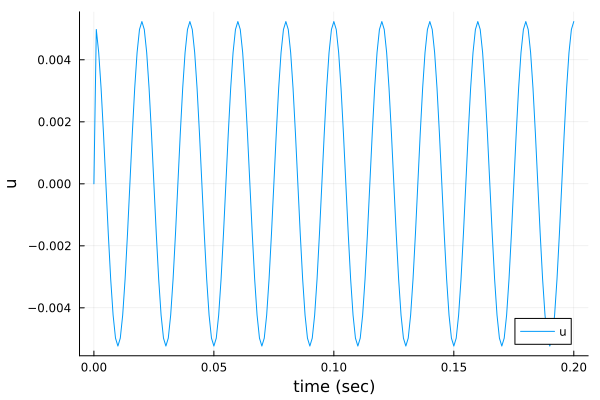

In [8]:
plot(time_steps, real(u_wave), label = "u")
xlabel!("time (sec)")
ylabel!("u")

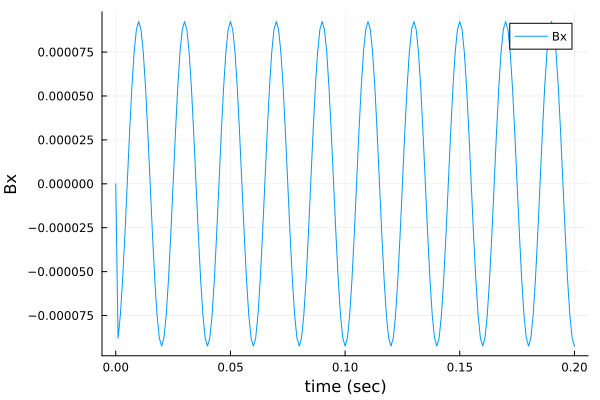

In [9]:
plot(time_steps, real(Bx_wave), label = "Bx")
xlabel!("time (sec)")
ylabel!("Bx")

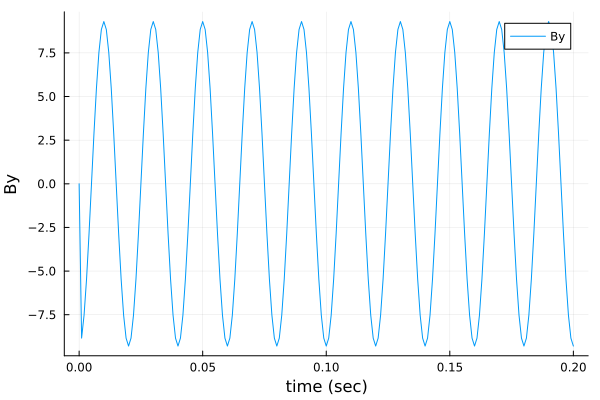

In [10]:
plot(time_steps, real(By_wave), label = "By")
xlabel!("time (sec)")
ylabel!("By")

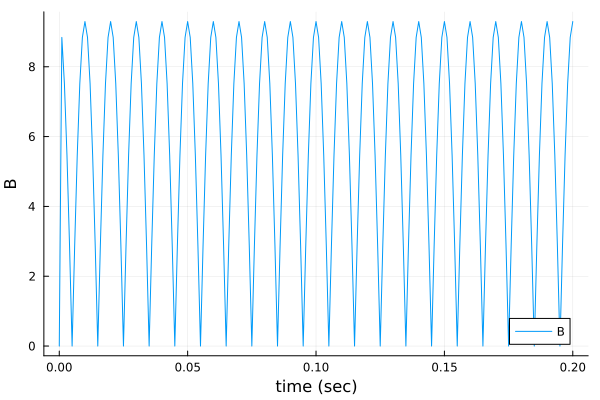

In [11]:
plot(time_steps, real(B_wave), label = "B")
xlabel!("time (sec)")
ylabel!("B")

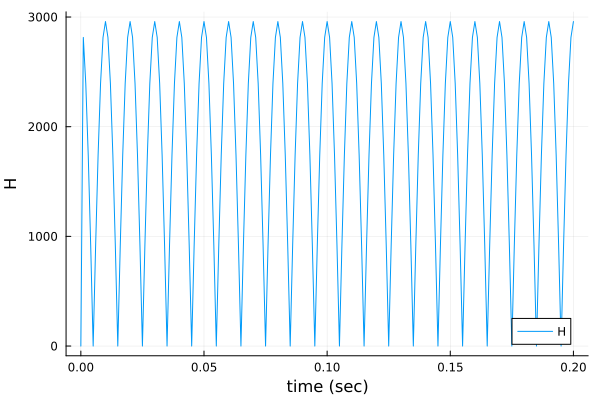

In [12]:
plot(time_steps, real(H_wave), label = "H")
xlabel!("time (sec)")
ylabel!("H")